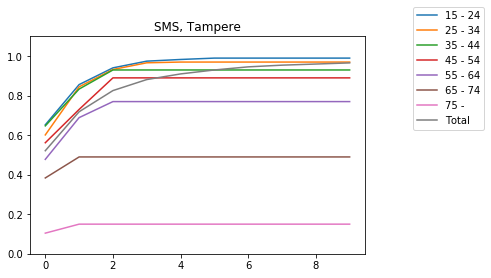

SMS, Tampere


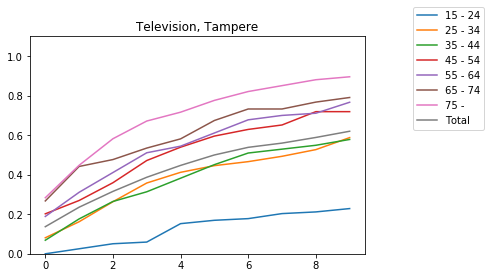

Television, Tampere


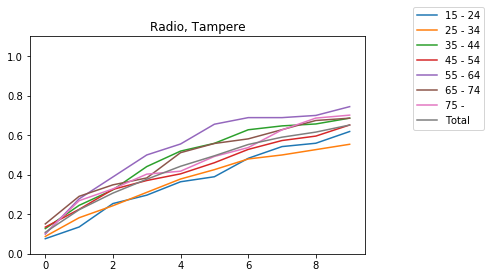

Radio, Tampere


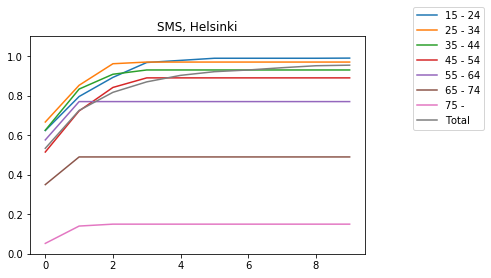

SMS, Helsinki


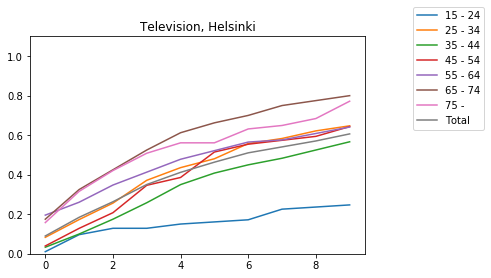

Television, Helsinki


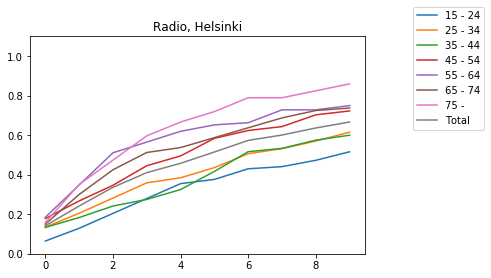

Radio, Helsinki


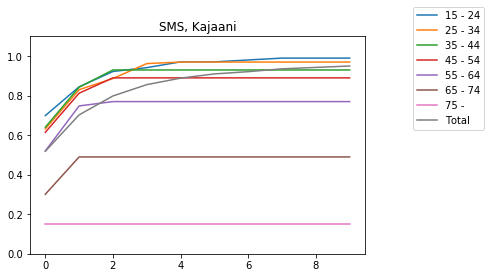

SMS, Kajaani


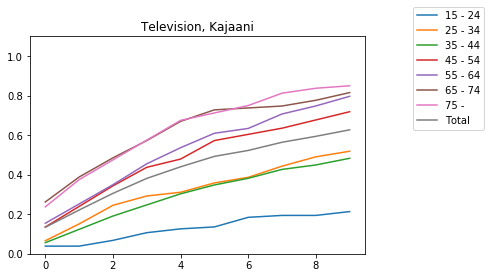

Television, Kajaani


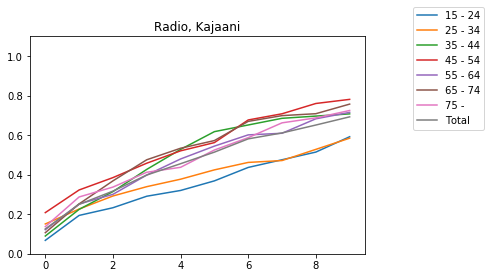

Radio, Kajaani


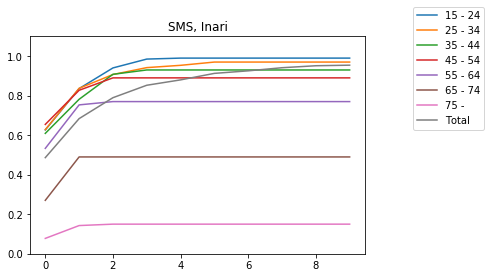

SMS, Inari


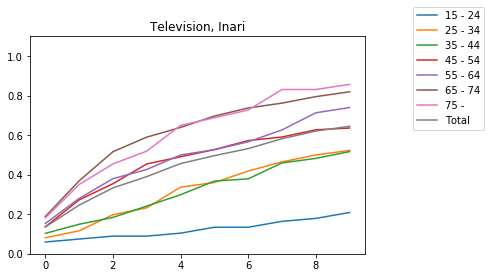

Television, Inari


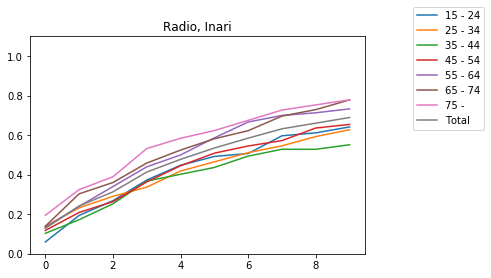

Radio, Inari


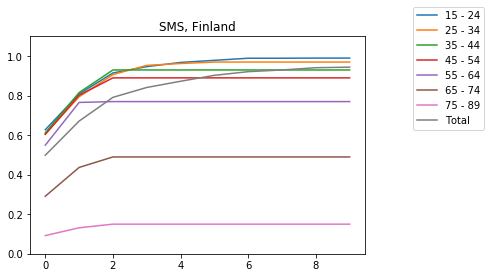

SMS, Finland


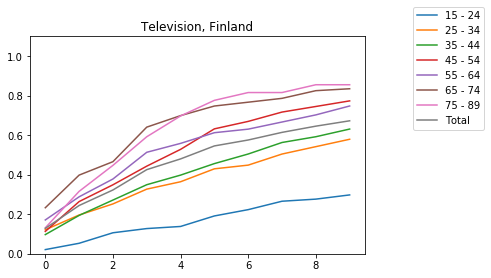

Television, Finland


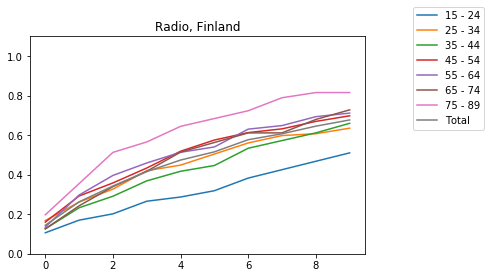

Radio, Finland


In [4]:
import numpy as np
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

reach = pd.read_csv('DailyReach.csv')

def get_population(pop_size):
    df_finland = pd.read_csv('vaerak_001_201700.csv', sep=';')
    df_helsinki = pd.read_csv('vaerak_helsinki.csv', sep=';')
    df_tampere = pd.read_csv('vaerak_tampere.csv', sep=';')
    df_kajaani = pd.read_csv('vaerak_kajaani.csv', sep=';')
    df_inari = pd.read_csv('vaerak_inari.csv', sep=';')
    
    #df_finland = df_finland.rename(columns={'75 - 89':'75 -'})

    populations = [df_finland, df_helsinki, df_tampere, df_kajaani, df_inari]

    # Normalize populations to pop_size
    for frame in populations:
        normalize = 1.0/(frame['Population 2017'].sum())
        frame['Population 2017'] = frame['Population 2017'] * pop_size * normalize
        frame['Population 2017'] = frame['Population 2017'].apply(np.round).apply(np.int)

    populations = pd.concat(populations)
    return populations

def iterfunc(y):
    x = np.random.random()
    if x < y:
        return 1
    else:
        return 0


# Possile areas: 'Finland', 'Helsinki', 'Tampere', 'Kajaani', 'Inari'
# pop_size: integer
def simulate_radio(set_area, pop_size, steps):
    df_r = pd.read_csv('english_radio_listeninghours.csv')

    # Create propabilities from N(p0, p0/2) for whole population
    groups = []
    frames = []
    group_sizes = []
    populations = get_population(pop_size)
    for i in range(7):
        frame = populations.loc[populations.Area == set_area]
        n = frame.loc[i, 'Population 2017']
        age = frame.loc[i, 'Age']
        group_sizes.append(n)
        groups.append(np.random.normal(df_r.loc[i, 'Hours per week']/(24*7), df_r.loc[i, 'Hours per week']/(2*24*7), n))
        frames.append(pd.DataFrame({'probability' : groups[i], 'Age' : [age] * n}))

    df = pd.concat(frames, ignore_index=True)

    # limit propabilities #
    df.loc[df.probability < 0, 'probability'] = 0.0
    df.loc[df.probability > 0.5, 'probability'] = 0.5
    
    # Simulate #

    # Number of iterations
    # Interpretation: one iteration step corresponds to 1 min of broadcasted warning
#    steps = 10

    groups = df.Age.unique()

    pop = populations.loc[populations.Area == set_area]

    # The precentage of reached people is written in this DataFrame.
    results = pd.DataFrame()

    # Initialize 0 data frame for percentages
    # Create a column for each group
    for x in groups:
        results[x] = [0] * steps
    results['Total'] = [0] * steps

    # Iterations #

    # Who has been reached? A variable for each person
    df['reached'] = 0
    # A variable for remembering the previous step
    df['temp'] = 0

    #reach percentage for the radio
    reach_radio = reach.values[:,1]/100
    
    # Simulations for radio
    for i in range(steps):
        df.temp = df.reached
        df.reached = df.probability.apply(iterfunc)
        df.loc[df.temp == 1, 'reached'] = 1
        xx=0
        for x in groups:
            z = pop.loc[pop.Age == x, 'Population 2017'].iloc[0]
            results.loc[i, x] = df.loc[df.Age == x, 'reached'].sum()/z
            xx+=1
        results.loc[i, 'Total'] = df.reached.sum()/(pop['Population 2017'].sum())

    for x in results.columns:
        plt.plot(results[x], label=x)
        plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
    plt.title("Radio, " + str(set_area))
    plt.ylim(0.0,1.1)
    plt.savefig('plots\\radio_%s.png' % set_area, bbox_inches='tight')
    plt.show()

    print("Radio, " + str(set_area))
    #print(results)
    #results.to_csv('radio_results.csv')    
    return results


def simulate_tv(set_area, pop_size, steps):
    df_t = pd.read_csv('TV watched daily.csv')
    day = 60 * 24

    television_time = df_t.mean(axis=1)

    averages = []
    averages.append(television_time[1])
    averages.append(television_time[2])
    averages.append(television_time[2])
    averages.append(television_time[3])
    averages.append(television_time[3])
    averages.append(television_time[4])
    averages.append(television_time[4])

    populations = get_population(pop_size)
    groups = []
    frames = []
    for i in range(7):
        frame = populations.loc[populations.Area == set_area]
        n = frame.loc[i, 'Population 2017']
        age = frame.loc[i, 'Age']
        groups.append(np.random.normal(averages[i]/day, averages[i]/(2*day), n))
        frames.append(pd.DataFrame({'probability' : groups[i], 'Age' : [age] * n}))

    df = pd.concat(frames, ignore_index=True)

    # limit propabilities #
    df.loc[df.probability < 0, 'probability'] = 0.0
    df.loc[df.probability > 0.5, 'probability'] = 0.5

    # Simulate #

    # Number of iterations
    # Interpretation: one iteration step corresponds to 1 min of broadcasted warning
    # steps = 10

    groups = df.Age.unique()
    pop = populations.loc[populations.Area == set_area]

    # The precentage of reached people is written in this DataFrame.
    results = pd.DataFrame()

    # Initialize 0 data frame for percentages
    # Create a column for each group
    for x in groups:
        results[x] = [0] * steps
    results['Total'] = [0] * steps

    # Iterations #

    # Who has been reached? A variable for each person
    df['reached'] = 0
    # A variable for remembering the previous step
    df['temp'] = 0

    reach_tv = reach.values[:,2]/100
    # Simulations for television
    for i in range(steps):
        df.temp = df.reached
        df.reached = df.probability.apply(iterfunc)
        df.loc[df.temp == 1, 'reached'] = 1
        xx=0
        for x in groups:
            z = pop.loc[pop.Age == x, 'Population 2017'].iloc[0]
            results.loc[i, x] = df.loc[df.Age == x, 'reached'].sum()/z
            xx+=1
        results.loc[i, 'Total'] = df.reached.sum()/(pop['Population 2017'].sum())

    for x in results.columns:
        plt.plot(results[x], label=x)
        plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
    plt.title("Television, " + str(set_area))
    plt.ylim(0.0,1.1)
    plt.savefig('plots\\tv_%s.png' % set_area, bbox_inches='tight')
    plt.show()
    
    print("Television, " + str(set_area))
    #print(results)
    return results


def simulate_sms(set_area, pop_size, steps):
    # cellphone #
    phone1 = pd.read_csv('cellphone_usage.csv')
    reach_sms = phone1.values[:,2]/100
    
    phone = phone1[0:7]
    phone = phone.drop(columns='Used a cell phone in the last 3mos')

    populations = get_population(pop_size)
    # For those who own a cellphone:
    # Assume average of 8 h sleep and 6 h muted during day
    groups = []
    frames = []
    group_sizes = []
    for i in range(7):
        frame = populations.loc[populations.Area == set_area]
        n = frame.loc[i, 'Population 2017']
        age = frame.loc[i, 'Age']
        group_sizes.append(n)
        groups.append(np.random.normal(phone.loc[i, 'Owns a cellphone2)']*16/(24*100), phone.loc[i, 'Owns a cellphone2)']/(6*100), n))
        frames.append(pd.DataFrame({'propability' : groups[i], 'Age' : [age] * n}))

    df = pd.concat(frames, ignore_index=True)

    # limit propabilities #
    df.loc[df.propability < 0, 'propability'] = 0.0
    df.loc[df.propability > 1, 'propability'] = 1.0

    # Simulate #
    
    # Number of iterations
    # Interpretation: one iteration step corresponds ???
    #steps = 10

    groups = df.Age.unique()
    pop = populations.loc[populations.Area == set_area]

    # The precentage of reached people is written in this DataFrame.
    results = pd.DataFrame()

    # Initialize 0 data frame for percentages
    # Create a column for each group
    for x in groups:
        results[x] = [0] * steps
    results['Total'] = [0] * steps
    # Iterations #

    # Who has been reached? A variable for each person
    df['reached'] = 0
    # A variable for remembering the previous step
    df['temp'] = 0

    # Simulations for radio
    for i in range(steps):
        df.temp = df.reached
        df.reached = df.propability.apply(iterfunc)
        df.loc[df.temp == 1, 'reached'] = 1
        xx=0
        for x in groups:
            z = pop.loc[pop.Age == x, 'Population 2017'].iloc[0]
            #results.loc[i, x] = df.loc[df.Age == x, 'reached'].sum()/z
            results.loc[i, x] = np.minimum(df.loc[df.Age == x, 'reached'].sum()/z, reach_sms[xx])
            xx +=1
        results.loc[i, 'Total'] = df.reached.sum()/(pop['Population 2017'].sum())
        
    for x in results.columns:
        plt.plot(results[x], label=x)
        plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
    plt.title("SMS, " + str(set_area))
    plt.ylim(0.0,1.1)
    plt.savefig('plots\\phone_%s.png' % set_area, bbox_inches='tight')
    plt.show()
    
    #results.to_csv('phone_results.csv')

    print("SMS, " + str(set_area))
    #print(results)
    return results



#simulate_sms('Tampere', 700, 10)

#simulate_tv('Kajaani', 700, 10)

#simulate_radio('Kajaani', 700, 10)
res_sms = dict()
res_tv = dict()
res_radio = dict()
areas = ['Tampere', 'Helsinki', 'Kajaani', 'Inari', 'Finland']

for area in areas:
    res_sms[area] = simulate_sms(area, 700, 10)
    res_tv[area] = simulate_tv(area, 700, 10)
    res_radio[area] = simulate_radio(area, 700, 10)


In [11]:
indices = ['25%', '50%', '75%', '95%']
media = ['sms', 'tv', 'radio']
for media in media:
    for area in areas:
        vals = np.zeros((4,8))
        if media == 'sms':
            res = res_sms[area].copy()
        elif media == 'tv':
            res = res_tv[area].copy()
        elif media == 'radio':
            res = res_radio[area].copy()
        groups = list(res)
        res25 = res > 0.25
        res50 = res > 0.50
        res75 = res > 0.75
        res95 = res > 0.95
        ig = 0
        print('Percentiles for media ', media)
        for group in groups:
            try:
                tmp = res25[res25[group] == True].index[0]
            except IndexError:
                tmp = 999
                pass
            vals[0, ig] = tmp
            
            try:
                tmp = res50[res50[group] == True].index[0]
            except IndexError:
                tmp = 999
                pass
            vals[1, ig] = tmp
            try:
                tmp = res75[res75[group] == True].index[0]
            except IndexError:
                tmp = 999
                pass
            vals[2, ig] = tmp
            try:
                tmp = res95[res95[group] == True].index[0]
            except IndexError:
                tmp = 999
                pass
            vals[3, ig] = tmp
            
            ig+=1
        print('Percentiles for area', area,'. Alert round when the quantile is reached.')
        df_vals = pd.DataFrame(vals,index=indices,columns=groups).astype(int)
        print(df_vals)
        print()



Percentiles for media  sms
Percentiles for area Tampere . Alert round when the quantile is reached.
     15 - 24  25 - 34  35 - 44  45 - 54  55 - 64  65 - 74  75 -  Total
25%        0        0        0        0        0        0   999      0
50%        0        0        0        0        1      999   999      0
75%        1        1        1        2        2      999   999      2
95%        3        3      999      999      999      999   999      7

Percentiles for media  sms
Percentiles for area Helsinki . Alert round when the quantile is reached.
     15 - 24  25 - 34  35 - 44  45 - 54  55 - 64  65 - 74  75 -  Total
25%        0        0        0        0        0        0   999      0
50%        0        0        0        0        0      999   999      0
75%        1        1        1        2        1      999   999      2
95%        3        2      999      999      999      999   999      8

Percentiles for media  sms
Percentiles for area Kajaani . Alert round when the quantile